In [1]:
import sys
sys.path.append('CIPS-Net')

import torch
import torch.nn as nn
from models.cips_net import CIPSNet
from torchinfo import summary
import numpy as np

In [2]:
# Reload modules to pick up changes
import importlib
import sys

# Remove cached modules
modules_to_reload = [
    'CIPS-Net.models.image_encoder',
    'CIPS-Net.models.text_encoder',
    'CIPS-Net.models.instruction_grounding',
    'CIPS-Net.models.decoder',
    'CIPS-Net.models.cips_net',
    'CIPS-Net.models'
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]

# Re-import
from models.cips_net import CIPSNet
print("✓ Modules reloaded!")

✓ Modules reloaded!


## 1. Initialize CIPS-Net Model

In [3]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize model with lightweight models (~340MB total instead of 800MB+)
print("\nInitializing CIPS-Net with lightweight models...")
print("📦 ViT-small (~80MB) + DistilBERT (~260MB)")
model = CIPSNet(
    img_encoder_name='vit_b_16',  # Will use ViT-small internally
    text_encoder_name="distilbert-base-uncased",  # Lighter than Clinical-BERT
    embed_dim=768,
    num_classes=5,
    img_size=224,
    num_graph_layers=3,
    decoder_channels=[512, 256, 128, 64],
    freeze_text_encoder=False,
    pretrained=False  # Set to True when you have internet and want pretrained weights
)

print("✓ Model initialized successfully!")

Using device: cuda

Initializing CIPS-Net with lightweight models...
📦 ViT-small (~80MB) + DistilBERT (~260MB)
✓ Model initialized successfully!


## 2. Model Information

In [4]:
# Get model information
model_info = model.get_model_info()

print("="*80)
print("CIPS-NET MODEL INFORMATION")
print("="*80)

for key, value in model_info.items():
    if key == 'class_names':
        print(f"\n{key}:")
        for i, name in enumerate(value):
            print(f"  {i}. {name}")
    elif key in ['total_parameters', 'trainable_parameters']:
        print(f"{key}: {value:,}")
    else:
        print(f"{key}: {value}")

CIPS-NET MODEL INFORMATION
model_name: CIPS-Net
image_encoder: vit_b_16
text_encoder: distilbert-base-uncased
embed_dim: 768
num_classes: 5
img_size: 224
total_parameters: 120,601,349
trainable_parameters: 120,601,349

class_names:
  0. Neoplastic
  1. Inflammatory
  2. Connective_Soft_tissue
  3. Epithelial
  4. Dead
  5. Background


## 3. Module-wise Parameter Counts

In [5]:
print("\n" + "="*80)
print("MODULE-WISE PARAMETER COUNTS")
print("="*80)

def count_parameters(module):
    return sum(p.numel() for p in module.parameters())

def count_trainable_parameters(module):
    return sum(p.numel() for p in module.parameters() if p.requires_grad)

modules = [
    ('Image Encoder (ViT)', model.image_encoder),
    ('Text Encoder (Clinical-BERT)', model.text_encoder),
    ('Grounding Module (Graph Reasoning)', model.grounding_module),
    ('Segmentation Decoder', model.decoder),
]

print(f"{'Module':<45} {'Total Params':>15} {'Trainable':>15}")
print("-" * 80)

total_all = 0
trainable_all = 0

for name, module in modules:
    total = count_parameters(module)
    trainable = count_trainable_parameters(module)
    total_all += total
    trainable_all += trainable
    print(f"{name:<45} {total:>15,} {trainable:>15,}")

print("-" * 80)
print(f"{'TOTAL':<45} {total_all:>15,} {trainable_all:>15,}")
print(f"\nTrainable percentage: {(trainable_all/total_all)*100:.2f}%")


MODULE-WISE PARAMETER COUNTS
Module                                           Total Params       Trainable
--------------------------------------------------------------------------------
Image Encoder (ViT)                                22,110,720      22,110,720
Text Encoder (Clinical-BERT)                       67,547,136      67,547,136
Grounding Module (Graph Reasoning)                 27,204,864      27,204,864
Segmentation Decoder                                3,738,629       3,738,629
--------------------------------------------------------------------------------
TOTAL                                             120,601,349     120,601,349

Trainable percentage: 100.00%


# Training Setup

Now let's prepare for training on the histopathology dataset.

In [6]:
# Import additional libraries for training
import pandas as pd
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
import os
from datetime import datetime

print("Training libraries imported!")

Training libraries imported!


In [7]:
# Load dataset and preprocess
df = pd.read_csv('Dataset/Images_With_Unique_Labels_Refer_Segmentation_Task.csv')
print(f"Dataset loaded: {len(df)} samples")
print(f"\nColumns: {df.columns.tolist()}")

# Parse classes into binary columns
class_names = ['Neoplastic', 'Inflammatory', 'Connective_Soft_tissue', 'Epithelial', 'Dead']

for class_name in class_names:
    df[class_name] = df['classes'].apply(lambda x: 1 if class_name in x else 0)

# Add mask paths - masks follow pattern: {base_name}_channel_{idx}_{class_name}.png
df['base_name'] = df['image_path'].str.replace('_img.png', '')

# Rename instruction column if it exists, otherwise use Caption
if 'instruction' in df.columns:
    df['Caption'] = df['instruction']

print(f"\nClass distribution:")
for col in class_names:
    count = df[col].sum()
    print(f"  {col}: {count} ({count/len(df)*100:.1f}%)")

Dataset loaded: 2720 samples

Columns: ['image_id', 'image_path', 'classes', 'organ', 'classes_clean', 'instruction']

Class distribution:
  Neoplastic: 2229 (81.9%)
  Inflammatory: 2326 (85.5%)
  Connective_Soft_tissue: 2652 (97.5%)
  Epithelial: 1061 (39.0%)
  Dead: 231 (8.5%)


In [8]:
# Custom Dataset Class
class HistopathologyDataset(Dataset):
    def __init__(self, dataframe, img_dir='Dataset/multi_images', mask_dir='Dataset/multi_masks', 
                 transform=None, img_size=224):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.img_size = img_size
        self.class_names = ['Neoplastic', 'Inflammatory', 'Connective_Soft_tissue', 'Epithelial', 'Dead']
        self.channel_mapping = {
            'Neoplastic': 0,
            'Inflammatory': 1,
            'Connective_Soft_tissue': 2,
            'Dead': 3,
            'Epithelial': 4
        }
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Load image
        img_path = os.path.join(self.img_dir, row['image_path'])
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Load masks for each class (following channel naming convention)
        base_name = row['base_name']
        masks = []
        
        for class_name in self.class_names:
            channel_idx = self.channel_mapping[class_name]
            mask_filename = f"{base_name}_channel_{channel_idx}_{class_name}.png"
            mask_path = os.path.join(self.mask_dir, mask_filename)
            
            if os.path.exists(mask_path):
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask = (mask > 127).astype(np.uint8)  # Binarize
            else:
                # If mask doesn't exist, create empty mask
                mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
            
            masks.append(mask)
        
        # Stack masks: [H, W, num_classes]
        masks = np.stack(masks, axis=-1)
        
        # Apply augmentations
        if self.transform:
            augmented = self.transform(image=image, mask=masks)
            image = augmented['image']
            masks = augmented['mask']
        
        # Convert to tensors - handle both numpy arrays and tensors
        if isinstance(image, np.ndarray):
            # Image from albumentations: [H, W, C] -> [C, H, W]
            image = torch.from_numpy(image).permute(2, 0, 1).float()
        elif isinstance(image, torch.Tensor) and image.ndim == 3 and image.shape[-1] == 3:
            # If already tensor but wrong order
            image = image.permute(2, 0, 1).float()
        
        if isinstance(masks, np.ndarray):
            # Masks from albumentations: [H, W, C] -> [C, H, W]
            masks = torch.from_numpy(masks).permute(2, 0, 1).float()
        elif isinstance(masks, torch.Tensor) and masks.ndim == 3 and masks.shape[-1] == len(self.class_names):
            # If already tensor but wrong order
            masks = masks.permute(2, 0, 1).float()
        
        # Get instruction/caption
        instruction = row['Caption'] if 'Caption' in row else row.get('instruction', 
                      self._generate_instruction(row))
        
        # Get class presence (binary vector)
        class_presence = torch.tensor([row[cls] for cls in self.class_names], dtype=torch.float32)
        
        return {
            'image': image,
            'masks': masks,
            'instruction': instruction,
            'class_presence': class_presence,
            'image_name': row['image_path']
        }
    
    def _generate_instruction(self, row):
        """Generate instruction from class labels if caption not available"""
        present_classes = [cls for cls in self.class_names if row[cls] == 1]
        if len(present_classes) == 0:
            return "Segment all tissue regions in this histopathology image."
        elif len(present_classes) == 1:
            return f"Segment {present_classes[0]} regions in this tissue sample."
        else:
            classes_str = ', '.join(present_classes[:-1]) + f' and {present_classes[-1]}'
            return f"Identify {classes_str} structures in this histopathology image."

print("Dataset class defined!")

Dataset class defined!


In [9]:
# Define augmentations (without ToTensorV2 for masks)
train_transform = A.Compose([
    A.Resize(224, 224),
    # A.HorizontalFlip(p=0.5),
    # A.VerticalFlip(p=0.5),
    # A.RandomRotate90(p=0.5),
    # A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    # A.GaussNoise(p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # Note: We'll manually convert to tensor to handle multi-channel masks
])

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Custom collate function to ensure proper tensor format
def custom_collate(batch):
    images = []
    masks = []
    instructions = []
    class_presence = []
    image_names = []
    
    for item in batch:
        images.append(item['image'])
        # Ensure masks are [C, H, W]
        mask = item['masks']
        if mask.shape[0] != 5:  # If not [C, H, W], permute
            mask = mask.permute(2, 0, 1)
        masks.append(mask)
        instructions.append(item['instruction'])
        class_presence.append(item['class_presence'])
        image_names.append(item['image_name'])
    
    return {
        'image': torch.stack(images),
        'masks': torch.stack(masks),
        'instruction': instructions,
        'class_presence': torch.stack(class_presence),
        'image_name': image_names
    }

# Train-val split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df[class_names].sum(axis=1))
print(f"Train samples: {len(train_df)}")
print(f"Val samples: {len(val_df)}")

# Create datasets
train_dataset = HistopathologyDataset(train_df, transform=train_transform)
val_dataset = HistopathologyDataset(val_df, transform=val_transform)

# Create dataloaders with custom collate
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, 
                          pin_memory=True, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, 
                        pin_memory=True, collate_fn=custom_collate)

print(f"\nDataLoaders created!")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Train samples: 2176
Val samples: 544

DataLoaders created!
Train batches: 68
Val batches: 17


In [10]:
# Metrics: Dice Score and IoU
def dice_score(pred, target, smooth=1e-6, per_class=False):
    """
    Calculate Dice score for binary masks
    pred: [B, C, H, W] - predicted masks (after sigmoid)
    target: [B, C, H, W] - ground truth masks
    per_class: If True, return per-class scores, else return mean
    """
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (union + smooth)
    
    if per_class:
        return dice.mean(dim=0)  # [C] - mean across batch for each class
    else:
        return dice.mean()  # scalar - mean across all

def iou_score(pred, target, smooth=1e-6, per_class=False):
    """
    Calculate IoU (Intersection over Union)
    pred: [B, C, H, W] - predicted masks (after sigmoid)
    target: [B, C, H, W] - ground truth masks
    per_class: If True, return per-class scores, else return mean
    """
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    
    if per_class:
        return iou.mean(dim=0)  # [C] - mean across batch for each class
    else:
        return iou.mean()  # scalar - mean across all

# Combined Loss: BCE + Dice Loss
class CombinedLoss(nn.Module):
    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super().__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.bce = nn.BCEWithLogitsLoss()
        
    def dice_loss(self, pred, target, smooth=1e-6):
        pred = torch.sigmoid(pred)
        intersection = (pred * target).sum(dim=(2, 3))
        union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
        dice = (2. * intersection + smooth) / (union + smooth)
        return 1 - dice.mean()
    
    def forward(self, pred, target):
        bce = self.bce(pred, target)
        dice = self.dice_loss(pred, target)
        return self.bce_weight * bce + self.dice_weight * dice

print("Metrics and loss functions defined!")

Metrics and loss functions defined!


In [11]:
# Training Configuration
config = {
    'num_epochs': 10,
    'learning_rate': 1e-4,
    'weight_decay': 1e-5,
    'device': device,
    'save_dir': 'checkpoints',
    'best_model_path': 'checkpoints/best_model.pth',
    'log_interval': 10,
}

# Create checkpoint directory
os.makedirs(config['save_dir'], exist_ok=True)

# Initialize model (reuse from above or create new)
# model = CIPSNet(
#     img_encoder_name='vit_b_16',
#     text_encoder_name="distilbert-base-uncased",
#     embed_dim=768,
#     num_classes=5,
#     img_size=224,
#     num_graph_layers=3,
#     decoder_channels=[512, 256, 128, 64],
#     freeze_text_encoder=False,
#     pretrained=False
# ).to(config['device'])

model = model.to(config['device'])
# Loss, optimizer, scheduler
criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5)
optimizer = AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
scheduler = CosineAnnealingLR(optimizer, T_max=config['num_epochs'], eta_min=1e-6)

print("Training configuration set!")
print(f"Device: {config['device']}")
print(f"Epochs: {config['num_epochs']}")
print(f"Learning rate: {config['learning_rate']}")

Training configuration set!
Device: cuda
Epochs: 10
Learning rate: 0.0001


In [12]:
# Training and Validation Functions
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    
    class_names = ['Neoplastic', 'Inflammatory', 'Connective', 'Epithelial', 'Dead']
    num_classes = len(class_names)
    
    running_loss = 0.0
    running_dice = torch.zeros(num_classes)
    running_iou = torch.zeros(num_classes)
    
    pbar = tqdm(loader, desc='Training', leave=False)
    for batch in pbar:
        images = batch['image'].to(device)
        masks = batch['masks'].to(device)
        instructions = batch['instruction']
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images, instructions)
        pred_masks = outputs['masks']  # [B, 5, H, W] - all tissue classes
        
        # Calculate loss
        loss = criterion(pred_masks, masks)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Calculate metrics
        with torch.no_grad():
            pred_sigmoid = torch.sigmoid(pred_masks)
            dice_per_class = dice_score(pred_sigmoid, masks, per_class=True)
            iou_per_class = iou_score(pred_sigmoid, masks, per_class=True)
        
        # Update running metrics
        running_loss += loss.item()
        running_dice += dice_per_class.cpu()
        running_iou += iou_per_class.cpu()
        
        # Update progress bar with mean metrics
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'dice': f'{dice_per_class.mean().item():.4f}',
            'iou': f'{iou_per_class.mean().item():.4f}'
        })
    
    # Calculate epoch averages
    epoch_loss = running_loss / len(loader)
    epoch_dice = running_dice / len(loader)
    epoch_iou = running_iou / len(loader)
    
    return epoch_loss, epoch_dice, epoch_iou

def validate_epoch(model, loader, criterion, device):
    model.eval()
    
    class_names = ['Neoplastic', 'Inflammatory', 'Connective', 'Epithelial', 'Dead']
    num_classes = len(class_names)
    
    running_loss = 0.0
    running_dice = torch.zeros(num_classes)
    running_iou = torch.zeros(num_classes)
    
    pbar = tqdm(loader, desc='Validation', leave=False)
    with torch.no_grad():
        for batch in pbar:
            images = batch['image'].to(device)
            masks = batch['masks'].to(device)
            instructions = batch['instruction']
            
            # Forward pass
            outputs = model(images, instructions)
            pred_masks = outputs['masks']  # [B, 5, H, W] - all tissue classes
            
            # Calculate loss
            loss = criterion(pred_masks, masks)
            
            # Calculate metrics
            pred_sigmoid = torch.sigmoid(pred_masks)
            dice_per_class = dice_score(pred_sigmoid, masks, per_class=True)
            iou_per_class = iou_score(pred_sigmoid, masks, per_class=True)
            
            # Update running metrics
            running_loss += loss.item()
            running_dice += dice_per_class.cpu()
            running_iou += iou_per_class.cpu()
            
            # Update progress bar with mean metrics
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'dice': f'{dice_per_class.mean().item():.4f}',
                'iou': f'{iou_per_class.mean().item():.4f}'
            })
    
    # Calculate epoch averages
    epoch_loss = running_loss / len(loader)
    epoch_dice = running_dice / len(loader)
    epoch_iou = running_iou / len(loader)
    
    return epoch_loss, epoch_dice, epoch_iou

print("Training and validation functions defined!")

Training and validation functions defined!


In [13]:
# Main Training Loop
class_names = ['Neoplastic', 'Inflammatory', 'Connective', 'Epithelial', 'Dead']

history = {
    'train_loss': [], 'train_dice': [], 'train_iou': [],
    'val_loss': [], 'val_dice': [], 'val_iou': []
}

best_val_dice = 0.0
start_time = datetime.now()

print("="*80)
print("STARTING TRAINING")
print("="*80)
print(f"Start time: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Batch size: {batch_size}")
print("="*80)

for epoch in range(config['num_epochs']):
    print(f"\nEpoch [{epoch+1}/{config['num_epochs']}]")
    print("-" * 80)
    
    # Train
    train_loss, train_dice, train_iou = train_epoch(
        model, train_loader, criterion, optimizer, config['device']
    )
    
    # Validate
    val_loss, val_dice, val_iou = validate_epoch(
        model, val_loader, criterion, config['device']
    )
    
    # Update learning rate
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # Save history (mean values)
    history['train_loss'].append(train_loss)
    history['train_dice'].append(train_dice.mean().item())
    history['train_iou'].append(train_iou.mean().item())
    history['val_loss'].append(val_loss)
    history['val_dice'].append(val_dice.mean().item())
    history['val_iou'].append(val_iou.mean().item())
    
    # Print epoch summary
    print(f"\n{'Metric':<20} {'Train':>12} {'Val':>12}")
    print("-" * 47)
    print(f"{'Loss':<20} {train_loss:>12.4f} {val_loss:>12.4f}")
    print(f"{'Dice Score (Mean)':<20} {train_dice.mean():>12.4f} {val_dice.mean():>12.4f}")
    print(f"{'IoU Score (Mean)':<20} {train_iou.mean():>12.4f} {val_iou.mean():>12.4f}")
    
    # Print per-class metrics
    print(f"\n{'Class':<20} {'Train Dice':>12} {'Val Dice':>12} {'Train IoU':>12} {'Val IoU':>12}")
    print("-" * 77)
    for i, class_name in enumerate(class_names):
        print(f"{class_name:<20} {train_dice[i]:>12.4f} {val_dice[i]:>12.4f} {train_iou[i]:>12.4f} {val_iou[i]:>12.4f}")
    
    print(f"\n{'Learning Rate':<20} {current_lr:>12.6f}")
    
    # Save best model
    val_dice_mean = val_dice.mean().item()
    if val_dice_mean > best_val_dice:
        best_val_dice = val_dice_mean
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_dice': val_dice_mean,
            'val_dice_per_class': val_dice.tolist(),
            'val_iou': val_iou.mean().item(),
            'val_iou_per_class': val_iou.tolist(),
            'val_loss': val_loss,
        }, config['best_model_path'])
        print(f"✓ Best model saved! (Mean Dice: {val_dice_mean:.4f})")
    
    # Save checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint_path = os.path.join(config['save_dir'], f'checkpoint_epoch_{epoch+1}.pth')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'history': history,
        }, checkpoint_path)
        print(f"Checkpoint saved: {checkpoint_path}")

end_time = datetime.now()
training_time = end_time - start_time

print("\n" + "="*80)
print("TRAINING COMPLETED!")
print("="*80)
print(f"End time: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Training duration: {training_time}")
print(f"Best validation Dice score: {best_val_dice:.4f}")
print(f"Best model saved at: {config['best_model_path']}")
print("="*80)

STARTING TRAINING
Start time: 2025-12-21 20:30:28
Training samples: 2176
Validation samples: 544
Batch size: 32

Epoch [1/10]
--------------------------------------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]


Metric                      Train          Val
-----------------------------------------------
Loss                       0.8184       0.7208
Dice Score (Mean)          0.0420       0.1359
IoU Score (Mean)           0.0299       0.1349

Class                  Train Dice     Val Dice    Train IoU      Val IoU
-----------------------------------------------------------------------------
Neoplastic                 0.0544       0.0016       0.0298       0.0008
Inflammatory               0.0164       0.5515       0.0114       0.5515
Connective                 0.0423       0.0045       0.0224       0.0023
Epithelial                 0.0228       0.0033       0.0127       0.0017
Dead                       0.0738       0.1188       0.0735       0.1182

Learning Rate            0.000098
✓ Best model saved! (Mean Dice: 0.1359)

Epoch [2/10]
--------------------------------------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]


Metric                      Train          Val
-----------------------------------------------
Loss                       0.7575       0.7477
Dice Score (Mean)          0.1889       0.3113
IoU Score (Mean)           0.1866       0.3108

Class                  Train Dice     Val Dice    Train IoU      Val IoU
-----------------------------------------------------------------------------
Neoplastic                 0.2264       0.5551       0.2249       0.5551
Inflammatory               0.5293       0.5516       0.5291       0.5515
Connective                 0.0711       0.3272       0.0657       0.3272
Epithelial                 0.0286       0.0034       0.0249       0.0018
Dead                       0.0889       0.1190       0.0886       0.1183

Learning Rate            0.000091
✓ Best model saved! (Mean Dice: 0.3113)

Epoch [3/10]
--------------------------------------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]


Metric                      Train          Val
-----------------------------------------------
Loss                       0.7266       0.7186
Dice Score (Mean)          0.3636       0.4745
IoU Score (Mean)           0.3633       0.4744

Class                  Train Dice     Val Dice    Train IoU      Val IoU
-----------------------------------------------------------------------------
Neoplastic                 0.5034       0.5551       0.5033       0.5551
Inflammatory               0.5949       0.5956       0.5948       0.5956
Connective                 0.2702       0.3272       0.2698       0.3272
Epithelial                 0.3609       0.7766       0.3600       0.7762
Dead                       0.0885       0.1179       0.0884       0.1178

Learning Rate            0.000080
✓ Best model saved! (Mean Dice: 0.4745)

Epoch [4/10]
--------------------------------------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]


Metric                      Train          Val
-----------------------------------------------
Loss                       0.7094       0.7012
Dice Score (Mean)          0.4346       0.4860
IoU Score (Mean)           0.4344       0.4860

Class                  Train Dice     Val Dice    Train IoU      Val IoU
-----------------------------------------------------------------------------
Neoplastic                 0.5012       0.5551       0.5011       0.5551
Inflammatory               0.6030       0.5956       0.6030       0.5956
Connective                 0.3051       0.3272       0.3049       0.3272
Epithelial                 0.7047       0.8346       0.7044       0.8346
Dead                       0.0590       0.1177       0.0589       0.1177

Learning Rate            0.000066
✓ Best model saved! (Mean Dice: 0.4860)

Epoch [5/10]
--------------------------------------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]


Metric                      Train          Val
-----------------------------------------------
Loss                       0.6984       0.6919
Dice Score (Mean)          0.4592       0.4860
IoU Score (Mean)           0.4590       0.4860

Class                  Train Dice     Val Dice    Train IoU      Val IoU
-----------------------------------------------------------------------------
Neoplastic                 0.5107       0.5551       0.5107       0.5551
Inflammatory               0.5979       0.5956       0.5979       0.5956
Connective                 0.3102       0.3272       0.3100       0.3272
Epithelial                 0.7411       0.8346       0.7410       0.8346
Dead                       0.1358       0.1177       0.1357       0.1177

Learning Rate            0.000051
✓ Best model saved! (Mean Dice: 0.4860)

Epoch [6/10]
--------------------------------------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]


Metric                      Train          Val
-----------------------------------------------
Loss                       0.6886       0.6840
Dice Score (Mean)          0.4871       0.4860
IoU Score (Mean)           0.4870       0.4860

Class                  Train Dice     Val Dice    Train IoU      Val IoU
-----------------------------------------------------------------------------
Neoplastic                 0.5322       0.5551       0.5322       0.5551
Inflammatory               0.5933       0.5956       0.5933       0.5956
Connective                 0.3192       0.3272       0.3191       0.3272
Epithelial                 0.7524       0.8346       0.7521       0.8346
Dead                       0.2386       0.1176       0.2385       0.1176

Learning Rate            0.000035

Epoch [7/10]
--------------------------------------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]


Metric                      Train          Val
-----------------------------------------------
Loss                       0.6821       0.6777
Dice Score (Mean)          0.5675       0.6441
IoU Score (Mean)           0.5675       0.6441

Class                  Train Dice     Val Dice    Train IoU      Val IoU
-----------------------------------------------------------------------------
Neoplastic                 0.5423       0.5551       0.5423       0.5551
Inflammatory               0.5933       0.5956       0.5933       0.5956
Connective                 0.3319       0.3272       0.3319       0.3272
Epithelial                 0.7837       0.8346       0.7836       0.8346
Dead                       0.5864       0.9081       0.5864       0.9081

Learning Rate            0.000021
✓ Best model saved! (Mean Dice: 0.6441)

Epoch [8/10]
--------------------------------------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]


Metric                      Train          Val
-----------------------------------------------
Loss                       0.6777       0.6749
Dice Score (Mean)          0.5590       0.6441
IoU Score (Mean)           0.5590       0.6441

Class                  Train Dice     Val Dice    Train IoU      Val IoU
-----------------------------------------------------------------------------
Neoplastic                 0.5386       0.5551       0.5386       0.5551
Inflammatory               0.5593       0.5956       0.5593       0.5956
Connective                 0.3052       0.3272       0.3052       0.3272
Epithelial                 0.7311       0.8346       0.7309       0.8346
Dead                       0.6609       0.9081       0.6609       0.9081

Learning Rate            0.000010

Epoch [9/10]
--------------------------------------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]


Metric                      Train          Val
-----------------------------------------------
Loss                       0.6731       0.6727
Dice Score (Mean)          0.5625       0.6441
IoU Score (Mean)           0.5624       0.6441

Class                  Train Dice     Val Dice    Train IoU      Val IoU
-----------------------------------------------------------------------------
Neoplastic                 0.5418       0.5551       0.5418       0.5551
Inflammatory               0.5731       0.5956       0.5731       0.5956
Connective                 0.3130       0.3272       0.3130       0.3272
Epithelial                 0.7300       0.8346       0.7299       0.8346
Dead                       0.6545       0.9081       0.6545       0.9081

Learning Rate            0.000003

Epoch [10/10]
--------------------------------------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]


Metric                      Train          Val
-----------------------------------------------
Loss                       0.6732       0.6719
Dice Score (Mean)          0.5720       0.6441
IoU Score (Mean)           0.5720       0.6441

Class                  Train Dice     Val Dice    Train IoU      Val IoU
-----------------------------------------------------------------------------
Neoplastic                 0.5427       0.5551       0.5427       0.5551
Inflammatory               0.5777       0.5956       0.5777       0.5956
Connective                 0.3199       0.3272       0.3199       0.3272
Epithelial                 0.7318       0.8346       0.7317       0.8346
Dead                       0.6880       0.9081       0.6880       0.9081

Learning Rate            0.000001
Checkpoint saved: checkpoints/checkpoint_epoch_10.pth

TRAINING COMPLETED!
End time: 2025-12-21 20:39:23
Training duration: 0:08:55.923577
Best validation Dice score: 0.6441
Best model saved at: checkpoints/best

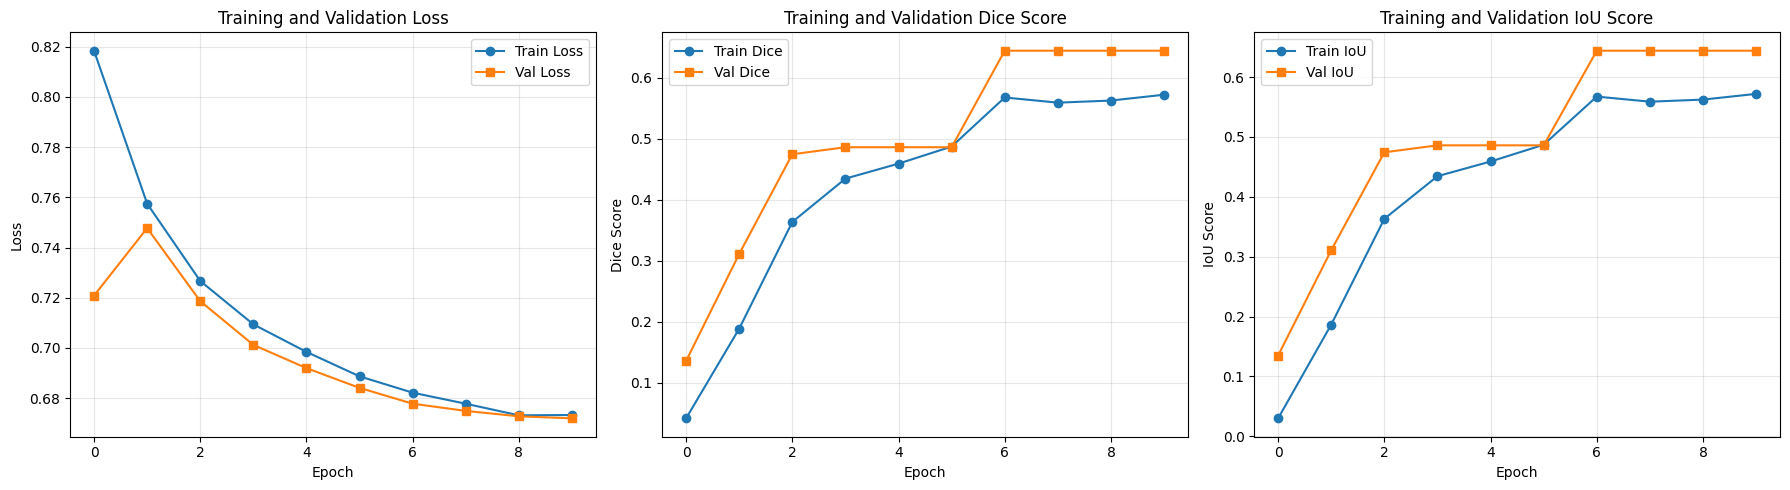

Training history plotted and saved!


In [17]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Dice score plot
axes[1].plot(history['train_dice'], label='Train Dice', marker='o')
axes[1].plot(history['val_dice'], label='Val Dice', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Dice Score')
axes[1].set_title('Training and Validation Dice Score')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# IoU plot
axes[2].plot(history['train_iou'], label='Train IoU', marker='o')
axes[2].plot(history['val_iou'], label='Val IoU', marker='s')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('IoU Score')
axes[2].set_title('Training and Validation IoU Score')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("Training history plotted and saved!")

In [29]:
loader = val_loader
model.eval()

class_names = ['Neoplastic', 'Inflammatory', 'Connective', 'Epithelial', 'Dead']
num_classes = len(class_names)

running_loss = 0.0
running_dice = torch.zeros(num_classes)
running_iou = torch.zeros(num_classes)

pbar = tqdm(loader, desc='Validation', leave=False)
with torch.no_grad():
    for batch in pbar:
        images = batch['image'].to(device)
        masks = batch['masks'].to(device)
        instructions = batch['instruction']
        
        # Forward pass
        outputs = model(images, instructions)
        pred_masks = outputs['masks']  # [B, 5, H, W] - all tissue classes
        
        # Calculate loss
        loss = criterion(pred_masks, masks)
        
        # Calculate metrics
        pred_sigmoid = torch.sigmoid(pred_masks)
        dice_per_class = dice_score(pred_sigmoid, masks, per_class=True)
        iou_per_class = iou_score(pred_sigmoid, masks, per_class=True)
        break


Validation:   0%|          | 0/17 [00:00<?, ?it/s]

In [ ]:
pred_masks = torch.sigmoid(outputs['masks'][0]) 
pred_masks_binary = (pred_masks > 0.5).float().cpu().numpy()

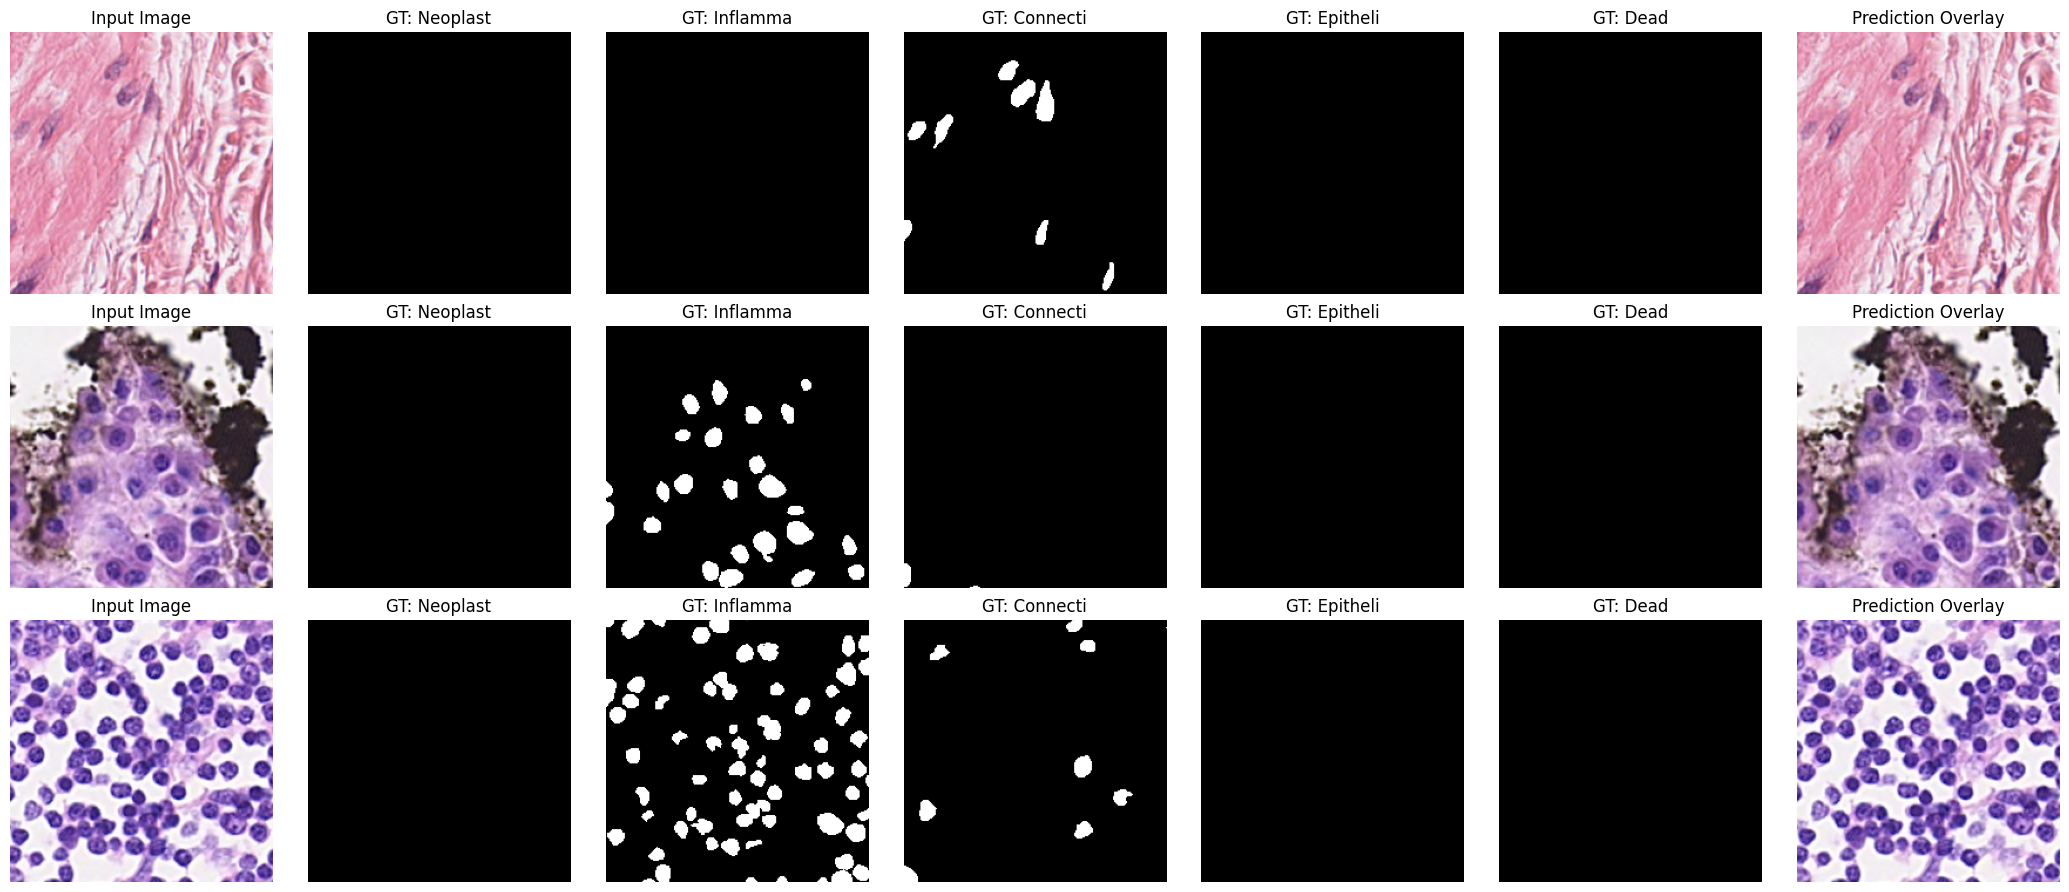

Visualization function defined!


In [25]:
# Visualize sample predictions
def visualize_predictions(model, dataset, device, num_samples=3):
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 7, figsize=(21, 3*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    class_names = ['Neoplastic', 'Inflammatory', 'Connective', 'Epithelial', 'Dead']
    
    with torch.no_grad():
        for i in range(num_samples):
            idx = np.random.randint(0, len(dataset))
            sample = dataset[idx]
            
            image = sample['image'].unsqueeze(0).to(device)
            instruction = [sample['instruction']]
            gt_masks = sample['masks']  # [5, H, W]
            
            # Get prediction
            outputs = model(image, instruction)
            pred_masks = torch.sigmoid(outputs['masks'][0])  # [5, H, W] - all tissue classes
            pred_masks = pred_masks.cpu()
            
            # Denormalize image for visualization
            img_display = image[0].cpu().permute(1, 2, 0).numpy()
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img_display = img_display * std + mean
            img_display = np.clip(img_display, 0, 1)
            
            # Plot image
            axes[i, 0].imshow(img_display)
            axes[i, 0].set_title('Input Image')
            axes[i, 0].axis('off')
            
            # Plot GT and predictions for each class
            for j in range(5):
                # Ground truth
                axes[i, j+1].imshow(gt_masks[j], cmap='gray', vmin=0, vmax=1)
                axes[i, j+1].set_title(f'GT: {class_names[j][:8]}')
                axes[i, j+1].axis('off')
            
            # Overlay prediction
            axes[i, 6].imshow(img_display)
            for j in range(5):
                mask_pred = (pred_masks[j] > 0.5).numpy()
                if mask_pred.sum() > 0:
                    contours = cv2.findContours((mask_pred*255).astype(np.uint8), 
                                               cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
                    for contour in contours:
                        contour = contour.squeeze()
                        if len(contour) > 2:
                            axes[i, 6].plot(contour[:, 0], contour[:, 1], 
                                          linewidth=2, label=class_names[j][:8])
            axes[i, 6].set_title('Prediction Overlay')
            axes[i, 6].axis('off')
            # if i == 0:
                # axes[i, 6].legend(loc='upper right', fontsize=8)
    
    plt.tight_layout()
    # plt.savefig('sample_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()
visualize_predictions(model, val_dataset, device, num_samples=3)
print("Visualization function defined!")

In [16]:
# Verify model outputs 5 channels (no background)
print("="*80)
print("VERIFYING MODEL OUTPUT SHAPE")
print("="*80)

model_test = CIPSNet(
    img_encoder_name='vit_b_16',
    text_encoder_name="distilbert-base-uncased",
    embed_dim=768,
    num_classes=5,
    img_size=224,
    num_graph_layers=3,
    decoder_channels=[512, 256, 128, 64],
    freeze_text_encoder=False,
    pretrained=False
).to(device)

# Test forward pass
test_img = torch.randn(2, 3, 224, 224).to(device)
test_instruction = ["Segment neoplastic tissue", "Identify inflammatory regions"]

with torch.no_grad():
    test_output = model_test(test_img, test_instruction)
    
print(f"Model output shape: {test_output['masks'].shape}")
print(f"Expected shape: [2, 5, 224, 224]")
print(f"✓ Background channel removed!" if test_output['masks'].shape[1] == 5 else "✗ Still has background channel")
print("="*80)

VERIFYING MODEL OUTPUT SHAPE
Model output shape: torch.Size([2, 5, 224, 224])
Expected shape: [2, 5, 224, 224]
✓ Background channel removed!
